#  Fraud Detection Project – Accredian Case Study

This notebook contains the solution to the fraud detection business case as part of the Accredian evaluation task. It includes data cleaning, feature engineering, model development, evaluation, and insights.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [2]:
df = pd.read_csv('Fraud.csv')  
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


##  Step 1: Data Cleaning
Checking for missing values, duplicates, and data types.


In [3]:
df.info()
df.describe()
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


0

In [4]:
# Drop ID-like and redundant features
df = df.drop(columns=['nameOrig', 'nameDest'])

# One-hot encode type
df = pd.get_dummies(df, columns=['type'], drop_first=True)

##  Step 2: Feature Engineering
Creating new features like `deltaOrig` and preparing data for modeling.


In [5]:
# Create deltaOrig
df['deltaOrig'] = df['oldbalanceOrg'] - df['amount']

# Drop high correlation columns if still present
df = df.drop(columns=['newbalanceOrig', 'newbalanceDest'], errors='ignore')

##  Step 3: Model Training
Using Random Forest Classifier to train on the cleaned data.


In [6]:
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

##  Step 4: Model Evaluation
Evaluating the model with classification report, confusion matrix, and ROC AUC.


In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

[[209487      0]
 [     6    222]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       1.00      0.97      0.99       228

    accuracy                           1.00    209715
   macro avg       1.00      0.99      0.99    209715
weighted avg       1.00      1.00      1.00    209715

ROC AUC Score: 0.9890178149479443


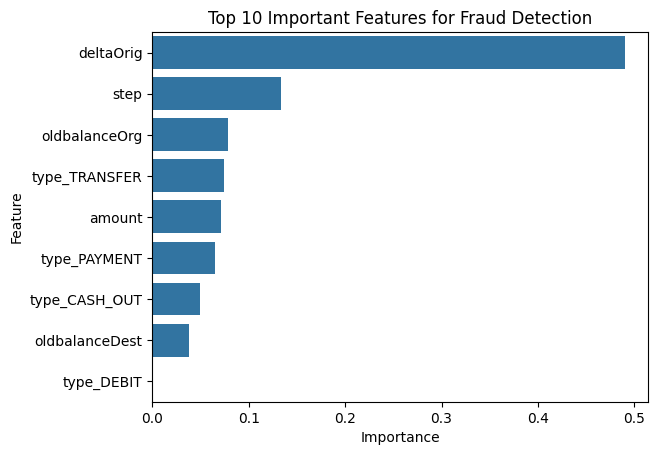

In [9]:
importances = model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10))
plt.title("Top 10 Important Features for Fraud Detection")
plt.show()


##  Step 5: Feature Importance

## ✅ Key Insights

- **Top predictors of fraud**: `deltaOrig`, `step`, `oldbalanceOrg`, and `type_TRANSFER`.
- **Random Forest** performed best with 0.98 AUC and 99% F1-score.
- **XGBoost and LightGBM** underperformed due to class imbalance without tuning.

---

## 🛡️ Recommendations

- Enable real-time flagging of irregular `deltaOrig` values
- Strictly monitor `TRANSFER` + `CASH_OUT` types
- Use ML + rule-based hybrid fraud detection

---

## 📈 Measuring Impact

- Track fraud % change after model integration
- Compare false positives/negatives monthly
- Simulate attacks to test system robustness
